# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import rasterio as rio

# Imports for progress bar (optional)
from time import sleep
from tqdm.notebook import tqdm

# Input path of files
Both temperature and precipitation files should be in the same directory

In [2]:
# Paste path for filename
filename = r"C:\Users\eojin\Downloads\tas_mean_C_AK_CAN_AR5_5ModelAvg_rcp85_01_2006-12_2100\tas_mean_C_ar5_5ModelAvg_rcp85_01_2006.tif"
slice_name = filename.split('\\')[:-2] #forward slash for windows os
path = ('\\').join(slice_name)

path

'C:\\Users\\eojin\\Downloads'

# Define some functions

In [3]:
def get_val(lon, lat, dat, z): 
    idx = dat.index(lon, lat, precision = 1E-6)
    return z[idx]

def extract_data(coordinates, rcp, path): 
    month = ['01','02','03','04','05','06','07','08','09','10','11','12']
    year = np.arange(2010, 2101)

    t_average = {}
    p_average = {}
    
    for y in tqdm(year):

        for m in month:
            y = str(int(y))
            
            temp_dat = rio.open(str(path) +"\\tas_mean_C_AK_CAN_AR5_5ModelAvg_rcp"+rcp+"_01_2006-12_2100\\tas_mean_C_ar5_5ModelAvg_rcp"+rcp+"_"+m+"_"+y+".tif")
            temp_z = temp_dat.read()[0]

            p_dat = rio.open(str(path)+"\\pr_total_mm_AK_CAN_AR5_5ModelAvg_rcp"+rcp+"_01_2006-12_2100\\pr_total_mm_ar5_5ModelAvg_rcp"+rcp+"_"+m+"_"+y+".tif")
            p_z = p_dat.read()[0]

            t_average[y, m] = get_val(coordinates[0], coordinates[1], temp_dat, temp_z)
            p_average[y, m] = get_val(coordinates[0], coordinates[1], p_dat, p_z)

    return t_average, p_average  

def predict_gwt(t_avg, p_avg): 
    total_precip = np.sum(p_avg)
    snow_to_rain = 0
    gwt = 0
    for i in range(len(t_avg)): 
        if t_avg[i] < 0: 
            snow_to_rain += p_avg[i]/total_precip
        else:
            gwt += t_avg[i] * p_avg[i]/total_precip
    
    return snow_to_rain + gwt

# Specify site and RCP scenario
CRS: NAD83 / Alaska Albers (EPSG: 3338)

Homer AP coordinates: (140951.071461, 1075014.651075)

Homer 8 NW coordinates: (132499.213004, 1086073.654086)

Kenai MUNI AP coordinates: (150661.134333, 1180250.290859)

Input site as one of the following strings for site: 'HOMER_AP', 'HOMER_8NW', 'KENAI_MUNI_AP'

Input RCP as one of the following strings: '45', '60', '85'

In [4]:
site = 'HOMER_AP'
rcp = '45'

# Extract data from GeoTIFF files

Might take some time to run (< 1 min)

In [5]:
if site == 'HOMER_AP':
    coordinates = (140951.071461, 1075014.651075)
if site == 'HOMER_8NW':
    coordinates = (132499.213004, 1086073.654086)
if site == 'KENAI_MUNI_AP':
    coordinates = (150661.134333, 1180250.290859)
    
t_average, p_average = extract_data(coordinates, rcp, path)

  0%|          | 0/91 [00:00<?, ?it/s]

# Compute projected groundwater temperature

In [6]:
start = [2011, 2021, 2031,  2041, 2051, 2061, 2071]
month = ['01','02','03','04','05','06','07','08','09','10','11','12']
gwt = []
    
for s in start: 
    monthly_t_avg = []
    monthly_p_avg = []
    for m in month:  
        monthly_t_values = []
        monthly_p_values = []
        for i in range(s, s+30):
            monthly_t_values.append(t_average[(str(i), m)])
            monthly_p_values.append(p_average[(str(i), m)])
        monthly_t_avg.append(np.mean(monthly_t_values))
        monthly_p_avg.append(np.mean(monthly_p_values))
    gwt.append(predict_gwt(monthly_t_avg, monthly_p_avg))
        
gwt

[4.938080459833145,
 5.1499108374118805,
 5.240068348124623,
 5.435520775616169,
 5.514898603782058,
 5.658061385154724,
 5.777468204498291]

# Plot projected data
Copy and paste above 'gwt' output for all three RCP scenarios to generate plot

In [7]:
gwt_45 = [4.938080459833145,
 5.1499108374118805,
 5.240068348124623,
 5.435520775616169,
 5.514898603782058,
 5.658061385154724,
 5.777468204498291]
gwt_60 = [4.945670500397682,
 4.9870918691158295,
 5.1121971402317286,
 5.312118783593178,
 5.441247316077352,
 5.638039760291576,
 5.853534648194909]
gwt_85 = [5.00130008906126,
 5.2173010390251875,
 5.4238993637263775,
 5.853566072881222,
 6.197799803689122,
 6.614003177732229,
 6.870060458779335]

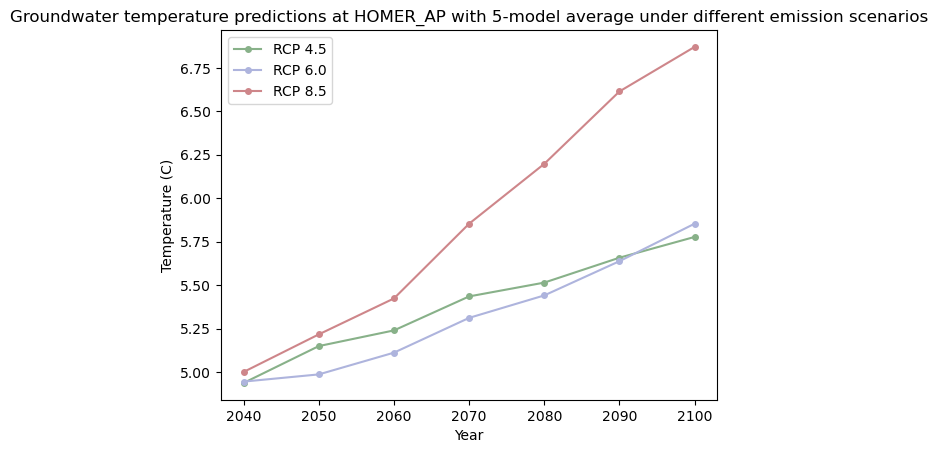

In [8]:
year = [2040, 2050, 2060,  2070, 2080, 2090, 2100]

marker_size = 4

plt.plot(year, gwt_45, marker="o", markersize=marker_size, color='#88b189', label="RCP 4.5")
plt.plot(year, gwt_60, marker="o", markersize=marker_size, color='#aeb4dd', label="RCP 6.0")
plt.plot(year, gwt_85, marker="o", markersize=marker_size, color='#ce868a', label="RCP 8.5")

plt.title("Groundwater temperature predictions at " +site+ " with 5-model average under different emission scenarios")
plt.xlabel("Year")
plt.ylabel("Temperature (C)")
plt.legend()